# Homework 2 - balancing & binning (deadline 28. 11. 2020)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.**
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
  
Give comments (!) on each step of your solution, with short explanations of your choices.

**If you do all this properly, you will obtain 16 points.** 

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

In [1]:
# imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, f1_score
from imblearn.under_sampling import TomekLinks

df = pd.read_csv('data.csv')
RANDOM_SEED = 21

In [2]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# print('SHAPE:')
# display(df.shape)  # (row, cols)
print('UNIQUE:')
display(df.nunique())
# print('INFO:')
# df.info()
print('DATA:')
display(df.head())
# print('DESCRIBE:')
# df.describe()
print('Poměr hodnot vysvětlované proměnné')
display(df['y'].value_counts())

UNIQUE:


y                   2
xind_01             8
xind_02_cat         5
xind_03            12
xind_04_cat         3
xind_05_cat         8
xind_06_bin         2
xind_07_bin         2
xind_08_bin         2
xind_09_bin         2
xind_10_bin         2
xind_11_bin         2
xind_12_bin         2
xind_13_bin         2
xind_14             5
xind_15            14
xind_16_bin         2
xind_17_bin         2
xind_18_bin         2
xreg_01            10
xreg_02            19
xreg_03          5013
xcar_01_cat        13
xcar_02_cat         3
xcar_03_cat         3
xcar_04_cat        10
xcar_05_cat         3
xcar_06_cat        18
xcar_07_cat         3
xcar_08_cat         2
xcar_09_cat         6
xcar_10_cat         3
xcar_11_cat       104
xcar_11             5
xcar_12           184
xcar_13         70482
xcar_14           850
xcar_15            15
xcalc_01           10
xcalc_02           10
xcalc_03           10
xcalc_04            6
xcalc_05            7
xcalc_06           11
xcalc_07           10
xcalc_08  

DATA:


,y,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
0,0,2,1,5,1,6,0,1,0,0,...,4,0,2,8,0,0,0,1,1,0
1,0,2,1,6,0,0,0,0,0,1,...,9,2,3,7,0,0,1,0,0,0
2,0,2,1,9,0,0,1,0,0,0,...,5,0,2,6,0,1,0,1,1,0
3,0,1,1,6,0,0,1,0,0,0,...,3,0,4,8,0,0,1,0,0,0
4,0,1,1,5,1,0,0,1,0,0,...,4,3,1,2,0,1,0,0,1,0


Poměr hodnot vysvětlované proměnné


0    573518
1     21694
Name: y, dtype: int64

Nejprve rozdělím data na 3 množiny. Trénovací, validační a testovací. Testovací množinu udělám nejmenší, protože bude sloužit pouze k reálnému zhodnocení celkových výsledků na konci experimentování.  

In [4]:
X = df.drop(['y'], axis=1)
Y = df['y']

X_tr, X_test, Y_tr, Y_test = train_test_split(X, Y, test_size=0.15 , random_state=RANDOM_SEED)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr, Y_tr, test_size=0.4, random_state=RANDOM_SEED)

Pro tuto úlohu jsem se rozhodl vyzkoušet 5 predikčních modelů:
* kNN
* Rozhodovací strom
* Random Forest
* AdaBoost
* Naivní Bayes

_pozn.:_
Pro zadané množství dat byl výpočet metody kNN velmi zdlouhavý, tak jsem ji nakonec nepoužil, protože by mne zdržovala při experimentování.

In [5]:
models = {
#     'kNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(max_depth=6),
    'Random Forest': RandomForestClassifier(max_depth=4, n_estimators=21, random_state=RANDOM_SEED),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_SEED),
    'Naive Bayes': GaussianNB(),
}

In [6]:
# metoda pro vypis uspesnosti predikce modelu
def printStats(Yval, Ypred, modelName):
    confM = confusion_matrix(Yval, Ypred)
    print(modelName + ':')
    print(confM)
    print('Normalized confusion matrix:')
    print(confM.astype('float') / confM.sum(axis=1)[:, np.newaxis])
    
    print('Tests:')
    print('Accuracy:', accuracy_score(Yval, Ypred))
    print('F1-score:', f1_score(Yval, Ypred))
    print('MSE:', mean_squared_error(Yval, Ypred))

In [7]:
# vypis vsech zkousenych modelu
for modelName in models.keys():
    trained_model = models[modelName].fit(X_tr, Y_tr)
    Y_pred = trained_model.predict(X_val)
    printStats(Y_val, Y_pred, modelName)
    print('----------------------------------------')    

Decision Tree:
[[194985     28]
 [  7354      5]]
Normalized confusion matrix:
[[9.99856420e-01 1.43580172e-04]
 [9.99320560e-01 6.79440141e-04]]
Tests:
Accuracy: 0.9635226217065602
F1-score: 0.001352813852813853
MSE: 0.036477378293439805
----------------------------------------
Random Forest:
[[195013      0]
 [  7359      0]]
Normalized confusion matrix:
[[1. 0.]
 [1. 0.]]
Tests:
Accuracy: 0.9636362737928171
F1-score: 0.0
MSE: 0.03636372620718281
----------------------------------------
AdaBoost:
[[195008      5]
 [  7354      5]]
Normalized confusion matrix:
[[9.99974361e-01 2.56393164e-05]
 [9.99320560e-01 6.79440141e-04]]
Tests:
Accuracy: 0.9636362737928171
F1-score: 0.0013570362328674175
MSE: 0.03636372620718281
----------------------------------------
Naive Bayes:
[[181738  13275]
 [  6419    940]]
Normalized confusion matrix:
[[0.93192762 0.06807238]
 [0.87226525 0.12773475]]
Tests:
Accuracy: 0.9026841657936868
F1-score: 0.08714193010104755
MSE: 0.09731583420631312
------------

Na základě výsledků získaných výše jsem se rozhodl pro porovnávání během experimentů použít model **Naivní Bayes**.
Modely _Random Forest_ a _AdaBoost_ mají sice větší přesnost predikce, ale na základě vytvořených kovariančních matic to vypadá, že jsou spíše přetrénované a kvůli nevyváženým hodnotám vysvětlované proměnné _y_ predikují vždy hodnoty y = 1.

Hodnota F-1 score potvrzuje, že kvalita predikcí je veeelmi špatná. Doufám, že toto balanční techniky dokáží napravit. Hodnota F1-score byla i důvodem proč jsem dal přednost Naivnímu Bayesovi oproti _Decision Tree_.

Poměr majoritní ku minoritní třídě je: 573518:21694

Tento nepoměr v datech vedl i k tomu, že jsem nejdříve implementoval bod 3 ze zadání ve snaze data vybalancovat a až poté diskretizovat pomocí biningu.

In [8]:
selectedModelName = 'Naive Bayes'

In [9]:
# pro opakovane vyhodnocovani modelu behem testovani
def evaluate(X_train, Y_train, X_validation, Y_validation):
    selectedModel = models[selectedModelName]
    Y_pred = selectedModel.fit(X_train, Y_train).predict(X_validation)
    printStats(Y_validation, Y_pred, selectedModelName)

### 3) Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results

Rozhodl jsem se použít obě techniky, které jsme probírali. Nejprve zkusím použít under-sampling na prvky z majoritní třídy (ta, kde y=0) a následně zkusím over-sampling na minoritní třídu prvků (y=1). V nejlepším případě každá metoda zlepší kvalitu predikcí vybraného modelu, v nejhorším ani jedna nepřinese zlepšení.

**Under-sampling**
* Původně jsem chtěl vybrat algoritmus CNN (Condensed Nearest Neighbor) - ten v kombinace s metodou Tomek Links tvoří velmi účinou (alespoň z přednášky jsem to tak pochopil) metodu. Ovšem po implementování (nyní zakomentováno) a spuštění CNN, když jsem ani po hodině stále neměl výsledky, jsem tuto metodu zavrhnul a pracoval raději se samotnými Tomkovými linky (spoji?).

In [10]:
# vyvazenost testovaci sady dat
print('Původní vyváženost trénovací množiny:')
display(Y_tr.value_counts())

Původní vyváženost trénovací množiny:


0    292485
1     11073
Name: y, dtype: int64

In [11]:
print('Původní počet dat:', len(Y_tr))

# print original prediction accuracy
print('Evaluace před under-samplingem:')
evaluate(X_tr, Y_tr, X_val, Y_val)
print('------------------------------------------')

# from imblearn.under_sampling import CondensedNearestNeighbour
# cnn = CondensedNearestNeighbour(
#     sampling_strategy='majority',  # protoze chci redukovat majoritni tridu prvku
#     random_state = RANDOM_SEED,
#     n_neighbors = 3,  # defaultne je 1, to mi prijde malo, 3 vidim jako optimalni hodnotu
#     n_jobs = -1
# )
# X_cnn_resampled, Y_cnn_resampled = cnn.fit_resample(X_tr, Y_tr)
# print('Po zredukování:', len(X_cnn_resample))
# print('Evaluace po undersamplingu:')
# evaluate(X_cnn_resampled, Y_cnn_resampled, X_val, Y_val)

tomek = TomekLinks(
    sampling_strategy='majority',  # protoze chci zredukovat majoritni tridu prvku
     n_jobs = -1
)
X_tomek_resampled, Y_tomek_resampled = tomek.fit_resample(X_tr, Y_tr)
print('Počet dat po zredukování:', len(X_tomek_resampled))
print('Vyváženost:')
display(Y_tomek_resampled.value_counts())
print('Evaluace po under-samplingu:')
evaluate(X_tomek_resampled, Y_tomek_resampled, X_val, Y_val)

Původní počet dat: 303558
Evaluace před under-samplingem:
Naive Bayes:
[[181738  13275]
 [  6419    940]]
Normalized confusion matrix:
[[0.93192762 0.06807238]
 [0.87226525 0.12773475]]
Tests:
Accuracy: 0.9026841657936868
F1-score: 0.08714193010104755
MSE: 0.09731583420631312
------------------------------------------
Počet dat po zredukování: 300261
Vyváženost:


0    289188
1     11073
Name: y, dtype: int64

Evaluace po under-samplingu:
Naive Bayes:
[[181483  13530]
 [  6398    961]]
Normalized confusion matrix:
[[0.93062001 0.06937999]
 [0.8694116  0.1305884 ]]
Tests:
Accuracy: 0.9015278793508984
F1-score: 0.08796338672768877
MSE: 0.09847212064910166


#### Vyhodnocení
Tomkovy linky zredukovaly majoritní třídu pouze o 3 297 prvků, což tvoří cca 2 % z celkového počtu prvků majoritní třídy. Doufal jsem, že ji zredukují více a data pak budou vybalancována, ale bohužel to podoba dat nejspíše neumožňovala a dataset je stále nevybalancovaný.

Bohužel výsledky testů se moc nezlepšily. Kovarianční matice se sice docela změnila (vypadá to, že se lépe klasifikují negativní prvky + je méně chyb 2. řádu, ale více chyb 1. řádu). Přesnost predikce a F1-score se změnily velmi nevýrazně, skoro bych i řekl, že se drobně zhoršily celkové výsledky (accuracy, mse se drobně zhoršily, F1-score se nevýznamně zlepšila). Tuto úpravu na data tedy nemá smysl aplikovat.

### **Over-sampling**
* Under-sampling mi nepřinesl zlepšení predikcí, tak jsem se rozhodl pro over-sampling použít rovnou 2 metody a doufal, že alespoň jedna z nich by data mohla vybalancovat.

* Vybral jsem metodu SMOTE (ta funguje na základě interpolace, kdy každému bodu najde _k_ nejbližsích sousedů a na každé spojnici k těmto sousedům nageneruje nový záznam), která je jedna z nejpopulárnějších over-samplingových metod. Dále jsem použil metodu SMOTEENN, která kombinuje metodu SMOTE v kombinaci s algoritmem ENN, pro získání lepších výsledků algoritmu SMOTE.

In [12]:
print('Původní počet dat:', len(X_tr))

# print original prediction accuracy
print('Evaluace před over-samplingem:')
evaluate(X_tr, Y_tr, X_val, Y_val)
print('------------------------------------------')

from imblearn.over_sampling import SMOTE
smot = SMOTE(sampling_strategy = 'minority', random_state = RANDOM_SEED, k_neighbors = 4)

X_smot_resampled, Y_smot_resampled = smot.fit_sample(X_tr, Y_tr)
print('Velikost dat po vygenerování nových bodů:', len(X_smot_resampled))
print('Vyváženost:')
display(Y_smot_resampled.value_counts())
print('Evaluace po over-samplingu:')
evaluate(X_smot_resampled, Y_smot_resampled, X_val, Y_val)

Původní počet dat: 303558
Evaluace před over-samplingem:
Naive Bayes:
[[181738  13275]
 [  6419    940]]
Normalized confusion matrix:
[[0.93192762 0.06807238]
 [0.87226525 0.12773475]]
Tests:
Accuracy: 0.9026841657936868
F1-score: 0.08714193010104755
MSE: 0.09731583420631312
------------------------------------------
Velikost dat po vygenerování nových bodů: 584970
Vyváženost:


1    292485
0    292485
Name: y, dtype: int64

Evaluace po over-samplingu:
Naive Bayes:
[[99094 95919]
 [ 3623  3736]]
Normalized confusion matrix:
[[0.50814048 0.49185952]
 [0.49232233 0.50767767]]
Tests:
Accuracy: 0.5081236534698476
F1-score: 0.0698226400284075
MSE: 0.4918763465301524


In [13]:
from imblearn.combine import SMOTEENN
smoteen = SMOTEENN(sampling_strategy = 'minority',random_state = RANDOM_SEED, smote = smot)

X_smoteen_resampled, Y_smoteen_resampled = smoteen.fit_sample(X_tr, Y_tr)
print('Původní počet dat:', len(Y_tr))
print('Velikost dat po vygenerování nových bodů:', len(X_smoteen_resampled))
print('Vyváženost:')
display(Y_smoteen_resampled.value_counts())
print('Evaluace po over-samplingu:')
evaluate(X_smoteen_resampled, Y_smoteen_resampled, X_val, Y_val)

Původní počet dat: 303558
Velikost dat po vygenerování nových bodů: 470023
Vyváženost:


1    292484
0    177539
Name: y, dtype: int64

Evaluace po over-samplingu:
Naive Bayes:
[[97741 97272]
 [ 3484  3875]]
Normalized confusion matrix:
[[0.50120248 0.49879752]
 [0.47343389 0.52656611]]
Tests:
Accuracy: 0.5021247998735003
F1-score: 0.0714246216799071
MSE: 0.4978752001264997


#### Vyhodnocení
* Dataset technika kvalitně vybalancovala, obě skupiny mají nyní stejný počet dat.
* Přesnost predikcí ovšem drasticky klesla (o 30 %!) společně se zhoršením F1-score (ta neklesla tak drasticky, ale také se zhoršila) a to jak u SMOTu, tak u SMOTEEN.
* Ani jednu z těchto technik bych tedy nepoužil ke zlepšení predikcí na vybraném datasetu.


**Důležitá poznámka:**
* během experimentů jsem v jednu chvíli jako hlavní model zvolil **Decision Tree**, který se nad původním datasetem chová velmi nevyváženě (predikuje skoro vždy vysvětlovanou proměnnou jako y=1).
* U tohoto modelu opět under-sampling metoda Tonkových spojů nepřinesla žádné zlepšení, ale u over-samplingu technika SMOTE již zlepšení přinesla.
* Pod tímto odstavcem přikládám pár zjištěných informací k over-samplingu pro tuto metodu a v následující buňce zobrazím hodnocení nad původními trénovacími daty a nad upravenými vybranou metodou SMOTE.
* Ve zbytku notebooku tedy ponechám jako hlavní volbu modelu právě onen **Decision Tree**

_Pozorování při použití **Decision Tree**_
* Po aplikování metody SMOTE se výsledky přesnosti predikcí zhoršily, data ovšem působí nyní trochu více vybalancovaně a to nejen kvůli počtu dat v minoritní a majoritní třídě (soudím tak také na základě toho, že predikce modelu nyní nejsou tak jednostranné).
* Navíc hodnota F1-score se výrazně zlepšila (výrazně oproti předchozí skoro nevýznamné hodnotě)
* SMOTEEN sice zlepšil hodnotu F1-score oproti SMOTu, ovšem tentokrát se mi zlepšení F1-score na úkor kvality predikce již nezdála vhodnou volbou.
* Rozhodl jsem se tedy původní dataset upravit a vybalancovat pomocí metody SMOTE

In [14]:
selectedModelName = 'Decision Tree'
print('Evaluace před over-samplingem:')
evaluate(X_tr, Y_tr, X_val, Y_val)
print('Evaluace po over-samplingu SMOTem:')
evaluate(X_smot_resampled, Y_smot_resampled, X_val, Y_val)

Evaluace před over-samplingem:
Decision Tree:
[[194986     27]
 [  7355      4]]
Normalized confusion matrix:
[[9.99861548e-01 1.38452308e-04]
 [9.99456448e-01 5.43552113e-04]]
Tests:
Accuracy: 0.9635226217065602
F1-score: 0.0010825439783491203
MSE: 0.036477378293439805
Evaluace po over-samplingu SMOTem:
Decision Tree:
[[173209  21804]
 [  6498    861]]
Normalized confusion matrix:
[[0.88819207 0.11180793]
 [0.88300041 0.11699959]]
Tests:
Accuracy: 0.860148637163244
F1-score: 0.057354116706634685
MSE: 0.13985136283675606


In [15]:
# ulozim upravy do promennych s finalni podobou dat
X_tr_final = X_smot_resampled
Y_tr_final = Y_smot_resampled

### 2) Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.

Již na základě prvotního pohledu na data jsem se rozhodl, že nejvhodnější bude aplikovat binning metody na hodnoty ve sloupcích **xcar_13** a **xreg_03**. Důvod byl jednoduchý -> biningem se snažím data zdiskretizovat a tyto sloupce obsahují spojité hodnoty a jako důsledek toho i nejvíce unikátních hodnot.

Pohled na data před samotným biningem je vidět v první buňce pod tímto markupem.

Bining provádím již nad upravenými daty po over-samplingu.

Rozhodnutí, do kolika binů a který typ biningu dělám nad trénovacími daty, poté před zkoumáním výsledků predikčního modelu aplikuji i na data z validační množiny. Má myšlenka za tímto postupem je následující: "Pokud se rozhodnu pro diskretizaci dat dané veličiny do x binů, tak tomu tak dělám na základě rozdělení dat. Předpokládám, že data ve validační (/testovací) množině by měla mít stejné rozdělení, proto stejná diskretizace bude vhodná i pro ně."

Realita samozřejmě může být jiná, ale do testovacích dat přece nikdy nevidím.

### Binning sloupce **xcar_13**

In [16]:
display(X_tr_final['xcar_13'].head(3))
print('Max: ', X_tr_final['xcar_13'].max(), '. Min: ', X_tr_final['xcar_13'].min())

0    1.213321
1    0.919935
2    0.576700
Name: xcar_13, dtype: float64

Max:  3.7206260026 . Min:  0.2911930432


count    584970.000000
mean          0.844714
std           0.237949
min           0.291193
25%           0.692006
50%           0.792723
75%           0.936551
max           3.720626
Name: xcar_13, dtype: float64

<AxesSubplot:>

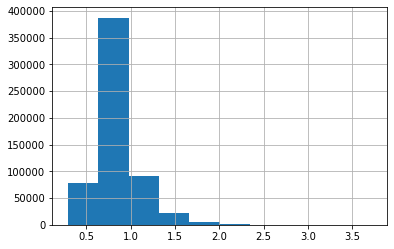

In [17]:
display(X_tr_final['xcar_13'].describe())
X_tr_final['xcar_13'].hist()

Sloupec **xcar_13** neobsahuje žádně chybějící hodnoty (soudím na základě toho, že chyb. hodnoty by měly být reprezentovány -1).

Po pohledu na histogram hodnot ze sloupce **xcar_13** to vypadá, že lepší řešení bude hodnoty rozdělit do binů na základě počtu prvků (aby v každém binu bylo stejně dat) namísto toho, aby měli stejné rozpětí (width).
* Jako důkaz této domněnky se pokusím data rozdělit i podle rozpětí dané hodnoty a výsledky pak porovnám.

Decision Tree:
[[173209  21804]
 [  6498    861]]
Normalized confusion matrix:
[[0.88819207 0.11180793]
 [0.88300041 0.11699959]]
Tests:
Accuracy: 0.860148637163244
F1-score: 0.057354116706634685
MSE: 0.13985136283675606
------------------------------------------
Decision Tree:
[[173209  21804]
 [  6498    861]]
Normalized confusion matrix:
[[0.88819207 0.11180793]
 [0.88300041 0.11699959]]
Tests:
Accuracy: 0.860148637163244
F1-score: 0.057354116706634685
MSE: 0.13985136283675606


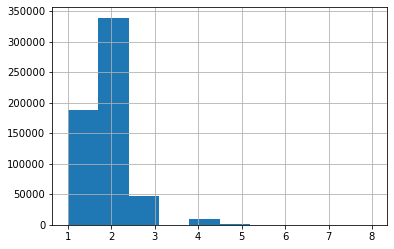

In [18]:
# zde si muzu zkusit jakkykoliv pocet binu, nikdy nebude rozdělení hodnot vyvážené
bins_xcar_width = [1, 2, 3, 4, 5, 6, 7, 8]
xcar_width = pd.cut(X_tr_final['xcar_13'], 8, labels=bins_xcar_width)
xcar_width.hist()

X_tr_car_width = X_tr_final.copy()
X_tr_car_width['xcar_13'] = xcar_width
# rozdeleni binu i ve validacni mnozine
X_val_car_width = X_val.copy()
X_val_car_width['xcar_13'] = pd.cut(X_val_car_width['xcar_13'], 8, labels=bins_xcar_width)

# original + modified data comparison
evaluate(X_tr_final, Y_tr_final, X_val, Y_val)
print('------------------------------------------')
evaluate(X_tr_car_width, Y_tr_final, X_val_car_width, Y_val)

Nyní rozdělení do rovnoměrně naplněných binů na základě počtu dat. (binning by height)

2    83586
4    83579
1    83572
7    83567
6    83567
5    83555
3    83544
Name: xcar_13, dtype: int64

[0.29119304 0.6394083  0.70599558 0.7621326  0.827822   0.90980529
 1.05787205 3.720626  ]


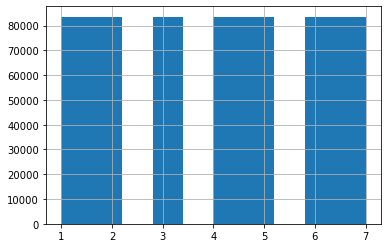

In [19]:
bins_xcar_height = [1, 2, 3, 4, 5, 6, 7]
X_tr_car_height = X_tr_final.copy()
X_tr_car_height['xcar_13'], bins = pd.qcut(X_tr_car_height['xcar_13'], 7, labels=bins_xcar_height, retbins=True)
# pohled na hodnoty po rozdeleni
X_tr_car_height['xcar_13'].hist()
display(X_tr_car_height['xcar_13'].value_counts())
print(bins)

In [20]:
# porovnani kvality predikce na puvodnich datech vs. na upravenych
evaluate(X_tr_final, Y_tr_final, X_val, Y_val)
print('------------------------------------------')

# rozdeleni binu i ve validacni mnozine
X_val_car_height = X_val.copy()
X_val_car_height['xcar_13'], bins = pd.qcut(X_val_car_height['xcar_13'], 7, labels=bins_xcar_height, retbins=True)
evaluate(X_tr_car_height, Y_tr_final, X_val_car_height, Y_val)

Decision Tree:
[[173209  21804]
 [  6498    861]]
Normalized confusion matrix:
[[0.88819207 0.11180793]
 [0.88300041 0.11699959]]
Tests:
Accuracy: 0.860148637163244
F1-score: 0.057354116706634685
MSE: 0.13985136283675606
------------------------------------------
Decision Tree:
[[173209  21804]
 [  6498    861]]
Normalized confusion matrix:
[[0.88819207 0.11180793]
 [0.88300041 0.11699959]]
Tests:
Accuracy: 0.860148637163244
F1-score: 0.057354116706634685
MSE: 0.13985136283675606


#### Vyhodnocení
Bohužel i přesto, že rozdělení dat ve sloupci **xcar_13** se zdálo jako dobrý nápad. Tak ani rozdělení podle šířky, ani podle výšky (které si stále myslím, že pro tento sloupec byla lepší volba) nedokázal pro vybraný model zlepšit hodnotu predikcí. S predikcemi to vůbec nehlo. + Hodnota F1-score je stále mizerná :(

### Binning sloupce **xreg_03**

count    584970.000000
mean          0.625662
std           0.719062
min          -1.000000
25%           0.550568
50%           0.759934
75%           1.039531
max           4.037945
Name: xreg_03, dtype: float64

,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,xind_10_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
4,2,3,7,1,0,0,0,0,1,0,...,5,0,1,8,0,1,1,0,1,0
9,0,1,4,1,6,0,1,0,0,0,...,4,2,4,5,0,1,1,0,0,0
19,1,1,5,0,0,0,1,0,0,0,...,4,3,4,7,0,1,1,0,0,0
20,1,1,2,0,0,0,1,0,0,0,...,4,2,1,5,0,1,1,0,0,0
25,5,3,4,1,4,0,0,1,0,0,...,6,1,4,3,0,0,0,0,0,1


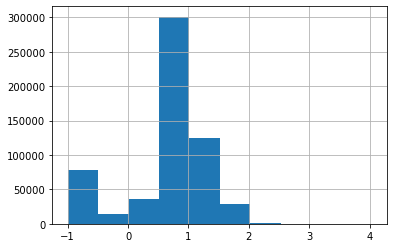

In [21]:
display(X_tr_final['xreg_03'].describe())
X_tr_final['xreg_03'].hist()
display(X_tr_final[X_tr_final['xreg_03'] == -1].head())
# X_tr_final['xreg_03'].unique()

Sloupec **xreg_03** obsahuje i chybějící hodnoty, ty bych nechal beze změny a binoval všechny ostatní.

Max:  4.0379450219 . Min:  -0.999889000658514


count    521173.000000
mean          0.824660
std           0.466088
min          -0.999889
25%           0.623498
50%           0.808548
75%           1.082026
max           4.037945
Name: xreg_03, dtype: float64

<AxesSubplot:>

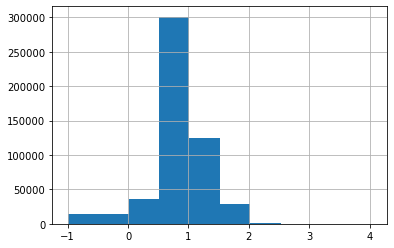

In [22]:
X_tr_xreg_no_missing_vals = X_tr_final[X_tr_final['xreg_03'] != -1].copy()
X_val_xreg_no_missing_vals = X_val[X_val['xreg_03'] != -1].copy()

print('Max: ', X_tr_xreg_no_missing_vals['xreg_03'].max(), '. Min: ', X_tr_xreg_no_missing_vals['xreg_03'].min())
display(X_tr_xreg_no_missing_vals['xreg_03'].describe())
X_tr_xreg_no_missing_vals['xreg_03'].hist()

Při pohledu na histogram hodnot ve sloupci si opět myslím, že hodnoty bude vhodnější rozdělit podle výšky (počtu prvků v jednotlivých binech) než šířky (na základě intervalů).

Opět provedu pro jistotu oboje.

Binning podle šířky

<AxesSubplot:>

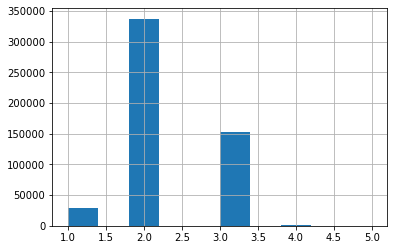

In [23]:
# při jakkemkoliv poctu binu budou hodnoty silně nevyvazene
bins_xreg_width = [1, 2, 3, 4, 5]

X_tr_xreg_no_missing_vals['xreg_03'] = pd.cut(X_tr_xreg_no_missing_vals['xreg_03'], 5, labels=bins_xreg_width)
X_tr_xreg_no_missing_vals['xreg_03'].hist()

In [24]:
X_tr_reg_width = X_tr_final.copy()
X_tr_reg_width = X_tr_reg_width[X_tr_reg_width['xreg_03'] == -1]
X_tr_reg_width = pd.concat([X_tr_reg_width, X_tr_xreg_no_missing_vals])
# rozdeleni binu i pro validacni mnozinu
X_val_reg_width = X_val.copy()
X_val_reg_width = X_val_reg_width[X_val_reg_width['xreg_03'] == -1]
X_val_xreg_no_missing_vals['xreg_03'] = pd.cut(X_val_xreg_no_missing_vals['xreg_03'], 5, labels=bins_xreg_width)
X_val_reg_width = pd.concat([X_val_reg_width, X_val_xreg_no_missing_vals])

# original + modified data comparison
evaluate(X_tr_final, Y_tr_final, X_val, Y_val)
print('------------------------------------------')
evaluate(X_tr_reg_width, Y_tr_final, X_val_reg_width, Y_val)

Decision Tree:
[[173209  21804]
 [  6498    861]]
Normalized confusion matrix:
[[0.88819207 0.11180793]
 [0.88300041 0.11699959]]
Tests:
Accuracy: 0.860148637163244
F1-score: 0.057354116706634685
MSE: 0.13985136283675606
------------------------------------------
Decision Tree:
[[112907  82106]
 [  4220   3139]]
Normalized confusion matrix:
[[0.57897166 0.42102834]
 [0.57344748 0.42655252]]
Tests:
Accuracy: 0.5734291305121262
F1-score: 0.06779404777331434
MSE: 0.4265708694878738


Binning podle výšky

1    130495
4    130293
3    130204
2    130181
Name: xreg_03, dtype: int64

[-0.999889    0.6234982   0.80854808  1.08202579  4.03794502]


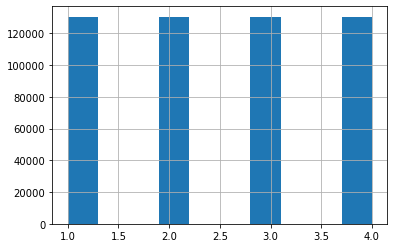

In [25]:
X_tr_xreg_no_missing_vals = X_tr_final[X_tr_final['xreg_03'] != -1].copy()
X_val_xreg_no_missing_vals = X_val[X_val['xreg_03'] != -1].copy()

bins_xreg_height = [1, 2, 3, 4]
X_tr_xreg_no_missing_vals['xreg_03'], bins = pd.qcut(X_tr_xreg_no_missing_vals['xreg_03'], 4, labels=bins_xreg_height, retbins=True)
# pohled na hodnoty rozdelene do binu
X_tr_xreg_no_missing_vals['xreg_03'].hist()
display(X_tr_xreg_no_missing_vals['xreg_03'].value_counts())
print(bins)

In [26]:
# porovnani kvality predikce na puvodnich datech vs. na upravenych
evaluate(X_tr_final, Y_tr_final, X_val, Y_val)
print('------------------------------------------')

X_tr_reg_height = X_tr_final.copy()
X_tr_reg_height = X_tr_reg_height[X_tr_reg_height['xreg_03'] == -1]
X_tr_reg_height = pd.concat([X_tr_reg_height, X_tr_xreg_no_missing_vals])
# rozdeleni binu i ve validacni mnozine
X_val_reg_height = X_val.copy()
X_val_reg_height = X_val_reg_height[X_val_reg_height['xreg_03'] == -1]
X_val_xreg_no_missing_vals['xreg_03'] = pd.cut(X_val_xreg_no_missing_vals['xreg_03'], 5, labels=bins_xreg_width)
X_val_reg_height = pd.concat([X_val_reg_height, X_val_xreg_no_missing_vals])

evaluate(X_tr_reg_height, Y_tr_final, X_val_reg_height, Y_val)

Decision Tree:
[[173209  21804]
 [  6498    861]]
Normalized confusion matrix:
[[0.88819207 0.11180793]
 [0.88300041 0.11699959]]
Tests:
Accuracy: 0.860148637163244
F1-score: 0.057354116706634685
MSE: 0.13985136283675606
------------------------------------------
Decision Tree:
[[181019  13994]
 [  6829    530]]
Normalized confusion matrix:
[[0.92824068 0.07175932]
 [0.92797935 0.07202065]]
Tests:
Accuracy: 0.897105330776985
F1-score: 0.0484394278663803
MSE: 0.10289466922301505


#### Vyhodnocení
* Na naměřených hodnotách pozitivně hodnotím, že oproti biningu u prvního zvoleného sloupce, kde se nic nezměnilo v predikcích, tak zde již změna v predikcích modelu možná vidět je.
* Má domněnka, že bining dle počtu prvků (bining by height) je vhodnější volba se potvrdila
* Binning zlepšil přesnost predikcí o 3 %. Hodnota F1-klesla mírně klesla, ale i tak hodnotím změnu pozitivně.

Tento bining tedy aplikuji na finální podobu mé trénovací množiny i testovací množiny.

In [27]:
X_tr_final = X_tr_reg_height

# rozbinovani hodnot i v testovaci mnozine
X_test_xreg_missing_vals = X_test[X_test['xreg_03'] == -1].copy()

X_test_xreg_no_missing_vals = X_test[X_test['xreg_03'] != -1].copy()
X_test_xreg_no_missing_vals['xreg_03'] = pd.cut(X_test_xreg_no_missing_vals['xreg_03'], 5, labels=bins_xreg_width)

X_test_final = pd.concat([X_test_xreg_missing_vals, X_test_xreg_no_missing_vals])

## Závěr
* Celkově musím přiznat, že se mi s datasetem velmi špatně pracovalo a obecně mě mátly velmi špatné získané hodnoty kvality predikcí (hlavně F1-score).
* Nakonec mi ovšem přišlo, že jsem datasetu dal nějaký řád, vybalancoval data a i úspěšně zdiskretizoval jednu proměnnou, takže myslím, že výsledek je vlastně celkem pozitivní.
* Na závěr ještě spustím finální porovnání a to výkon vybraného modelu nad původním datasetem vs. nad upraveným. To udělám nad testovací množinou dat, na kterou sem během všech experimentů nesahal.

In [28]:
print('Predikce nad puvodnimi daty:')
evaluate(X_tr, Y_tr, X_test, Y_test)

print('------------------------------------------')
# vs.
print('------------------------------------------')

print('Predikce nad upravenymi daty:')
evaluate(X_tr_final, Y_tr_final, X_test_final, Y_test)

Predikce nad puvodnimi daty:
Decision Tree:
[[86007    13]
 [ 3260     2]]
Normalized confusion matrix:
[[9.99848872e-01 1.51127645e-04]
 [9.99386879e-01 6.13120785e-04]]
Tests:
Accuracy: 0.9633408749803992
F1-score: 0.0012206286237412267
MSE: 0.036659125019600815
------------------------------------------
------------------------------------------
Predikce nad upravenymi daty:
Decision Tree:
[[79779  6241]
 [ 3012   250]]
Normalized confusion matrix:
[[0.92744711 0.07255289]
 [0.9233599  0.0766401 ]]
Tests:
Accuracy: 0.8963620886628884
F1-score: 0.05126627704296114
MSE: 0.10363791133711163


Přesnost predikce mě mile překvapila, přijde mi dobrá. Hodnota F1-score je stále mizerná, ale ta mě provázela po celou dobu experimentování s datasetem.